V3 computes test_loss for various train set sizes.

### Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

import elegy as eg
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

jnp.arange(0)  # Prints out any jax warnings.

DeviceArray([], dtype=int32)

In [3]:
sys.path.append("..")

import src.experiments.mlp_scaling as mlp_scaling

### Configure experiment

In [4]:
INPUT_SHAPE = (2,)
LAYER_WIDTHS = [96, 192, 1024, 42, 5, 1]
N_TEST = 2048

TEACHER_MOD = mlp_scaling.MLP(
    input_shape=INPUT_SHAPE,
    layer_widths=LAYER_WIDTHS,
)

STUDENT_MOD = mlp_scaling.MLP(
    input_shape=INPUT_SHAPE,
    layer_widths=LAYER_WIDTHS,
)

### Initialize teacher + create test set

┏━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ path     ┃ module   ┃ params                                ┃ Parameter        ┃
┡━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ *        │ MLP()    │                                       │                  │
├──────────┼──────────┼───────────────────────────────────────┼──────────────────┤
│ .linear  │ Linear() │ bias: Parameter(96)           float32 │ 288      1.2KB   │
│          │          │ kernel: Parameter(2, 96)      float32 │                  │
├──────────┼──────────┼───────────────────────────────────────┼──────────────────┤
│ .linear2 │ Linear() │ bias: Parameter(192)          float32 │ 18,624   74.5KB  │
│          │          │ kernel: Parameter(96, 192)    float32 │                  │
├──────────┼──────────┼───────────────────────────────────────┼──────────────────┤
│ .linear3 │ Linear() │ bias: Parameter(1024)         float32 │ 197,632  790.5KB │
│          │          │ kernel: Parameter(192, 1024)  float32 │                  │
├──────────┼──────────┼───────────────────────────────────────┼──────────────────┤
│ .linear4 │ Linear() │ bias: Parameter(42)           float32 │ 43,050   172.2KB │
│          │          │ kernel: Parameter(1024, 42)   float32 │                  │
├──────────┼──────────┼───────────────────────────────────────┼──────────────────┤
│ .linear5 │ Linear() │ bias: Parameter(5)            float32 │ 215      860B    │
│          │          │ kernel: Parameter(42, 5)      float32 │                  │
├──────────┼──────────┼───────────────────────────────────────┼──────────────────┤
│ .linear6 │ Linear() │ bias: Parameter(1)            float32 │ 6        24B     │
│          │          │ kernel: Parameter(5, 1)       float32 │                  │
├──────────┼──────────┼───────────────────────────────────────┼──────────────────┤
│          │          │                                Total: │ 259,815  1.0MB   │
└──────────┴──────────┴───────────────────────────────────────┴──────────────────┘
                                                                                  
                         Total Parameters: 259,815  1.0MB                         

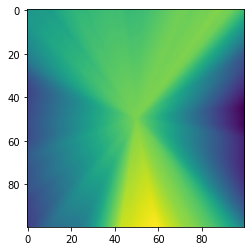

In [5]:
TEACHER = mlp_scaling.get_random_mlp(mlp=TEACHER_MOD, seed=-1)
DS_TEST = mlp_scaling.get_iid_dataset(
    model=TEACHER, n_samples=N_TEST, rng=jax.random.PRNGKey(-2)
)

mlp_scaling.viz_model(TEACHER, side_samples=100)
TEACHER.summary()

### Train student models

In [6]:
NS = [2 ** x for x in range(17)]
NS[0], NS[-1]

(1, 65536)

In [8]:
train_results = []

for n in NS:
    print(f"Training for {n=}")
    tr = mlp_scaling.train_student(
        student_mod=STUDENT_MOD,
        teacher=TEACHER,
        n_train_samples=n,
        ds_test=DS_TEST,
        seed=n,
    )
    
    train_results.append(tr)

Training for n=1
Epoch 1/512
0/1 [..............................] - 4s 0s/step - val_loss: 0.1438 - val_mean_squared_error_loss: 0.1438
Epoch 2/512
0/1 [..............................] - 0s 0s/step - val_loss: 0.1438 - val_mean_squared_error_loss: 0.1438
Epoch 3/512
0/1 [..............................] - 0s 0s/step - val_loss: 0.1438 - val_mean_squared_error_loss: 0.1438
Epoch 4/512
0/1 [..............................] - 0s 0s/step - val_loss: 0.1438 - val_mean_squared_error_loss: 0.1438
Training for n=2
Epoch 1/512
0/1 [..............................] - 3s 0s/step - val_loss: 1.0555 - val_mean_squared_error_loss: 1.0555
Epoch 2/512
0/1 [..............................] - 0s 0s/step - val_loss: 1.0555 - val_mean_squared_error_loss: 1.0555
Epoch 3/512
0/1 [..............................] - 0s 0s/step - val_loss: 1.0555 - val_mean_squared_error_loss: 1.0555
Epoch 4/512
0/1 [..............................] - 0s 0s/step - val_loss: 1.0555 - val_mean_squared_error_loss: 1.0555
Training for n

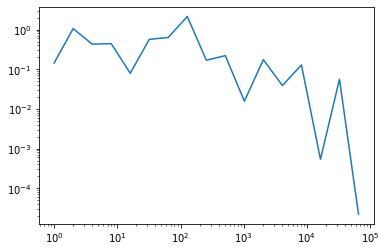

In [12]:
val_mses = [
    tr.history.history["val_mean_squared_error_loss"][0] for tr in train_results
]
plt.plot(NS, val_mses)
plt.xscale("log")
plt.yscale("log")

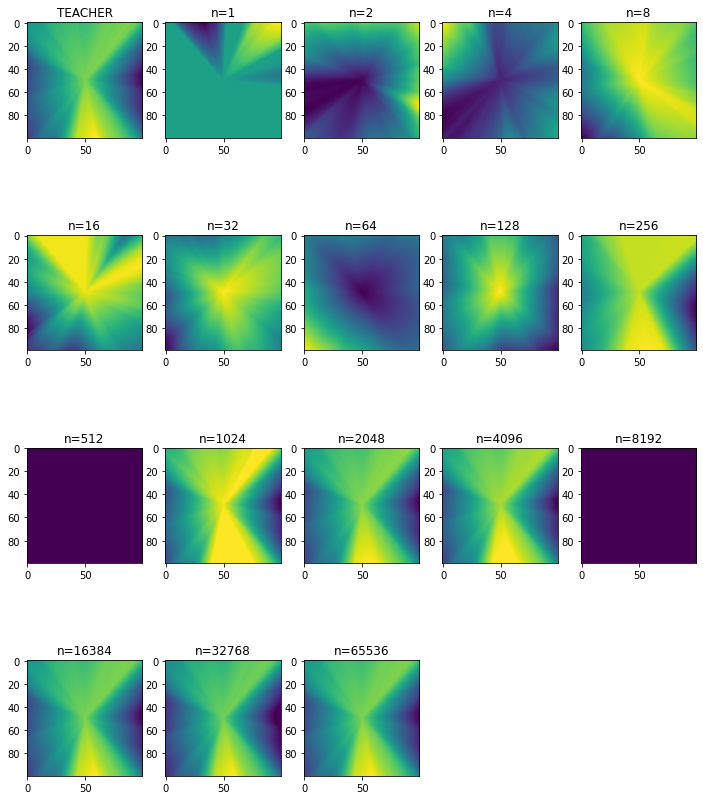

In [15]:
num_cols = 5
num_rows = len(NS) // num_cols + 1

plt.figure(figsize=(3 * num_rows, 3 * num_cols))

plt.subplot(num_rows, num_cols, 1)
mlp_scaling.viz_model(TEACHER, side_samples=100)
plt.title("TEACHER")

for i, n in enumerate(NS):
    plt.subplot(num_rows, num_cols, i + 2)
    mlp_scaling.viz_model(train_results[i].model, side_samples=100)
    plt.title(f"{n=}")